In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


In [ ]:
# Define the tickers and the time period
tickers = ['NVDA', 'AMD', 'INTC']
start_date = '2000-01-01'
end_date = '2024-09-30'

# Download the data
data = yf.download(tickers, start=start_date, end=end_date)


[*********************100%***********************]  3 of 3 completed


In [ ]:
# Select the 'Close' prices and drop any rows with missing values
close_prices = data['Close'].dropna()

# Reshape the data for each stock into a separate DataFrame
nvda_prices = close_prices['NVDA']
amd_prices = close_prices['AMD']
intc_prices = close_prices['INTC']


In [ ]:
def create_features(prices):
    # Convert Series to DataFrame
    df = pd.DataFrame(prices)
    df.columns = ['Close']  # Rename the column to 'Close'

    # Calculate returns
    df['Return'] = df['Close'].shift(-1) / df['Close'] - 1
    df.dropna(inplace=True)  # Drop rows with NaN values

    # Features (previous day's price)
    X = df[['Close']].shift(1).dropna()
    # Target (next day's return)
    y = df['Return'][1:]

    return X, y


In [ ]:
# Create features and target for each stock
X_nvda, y_nvda = create_features(nvda_prices)
X_amd, y_amd = create_features(amd_prices)
X_intc, y_intc = create_features(intc_prices)

In [ ]:
def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    return model, mse

# Train models for each stock
model_nvda, mse_nvda = train_model(X_nvda, y_nvda)
model_amd, mse_amd = train_model(X_amd, y_amd)
model_intc, mse_intc = train_model(X_intc, y_intc)

print(f'MSE for NVDA: {mse_nvda}')
print(f'MSE for AMD: {mse_amd}')
print(f'MSE for INTC: {mse_intc}')


MSE for NVDA: 0.0021824395083691072
MSE for AMD: 0.002091801671507678
MSE for INTC: 0.000933527712144521


In [ ]:
# Predict on the last available data point
last_nvda_price = np.array([[nvda_prices[-1]]])  # last known price for NVDA
predicted_return_nvda = model_nvda.predict(last_nvda_price)

last_amd_price = np.array([[amd_prices[-1]]])  # last known price for AMD
predicted_return_amd = model_amd.predict(last_amd_price)

last_intc_price = np.array([[intc_prices[-1]]])  # last known price for INTC
predicted_return_intc = model_intc.predict(last_intc_price)

print(f'Predicted return for NVDA: {predicted_return_nvda}')
print(f'Predicted return for AMD: {predicted_return_amd}')
print(f'Predicted return for INTC: {predicted_return_intc}')


Predicted return for NVDA: [0.03992205]
Predicted return for AMD: [0.0214627]
Predicted return for INTC: [-0.00550157]


<ipython-input-78-7327f0c11471>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_nvda_price = np.array([[nvda_prices[-1]]])  # last known price for NVDA
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
<ipython-input-78-7327f0c11471>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_amd_price = np.array([[amd_prices[-1]]])  # last known price for AMD
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForest

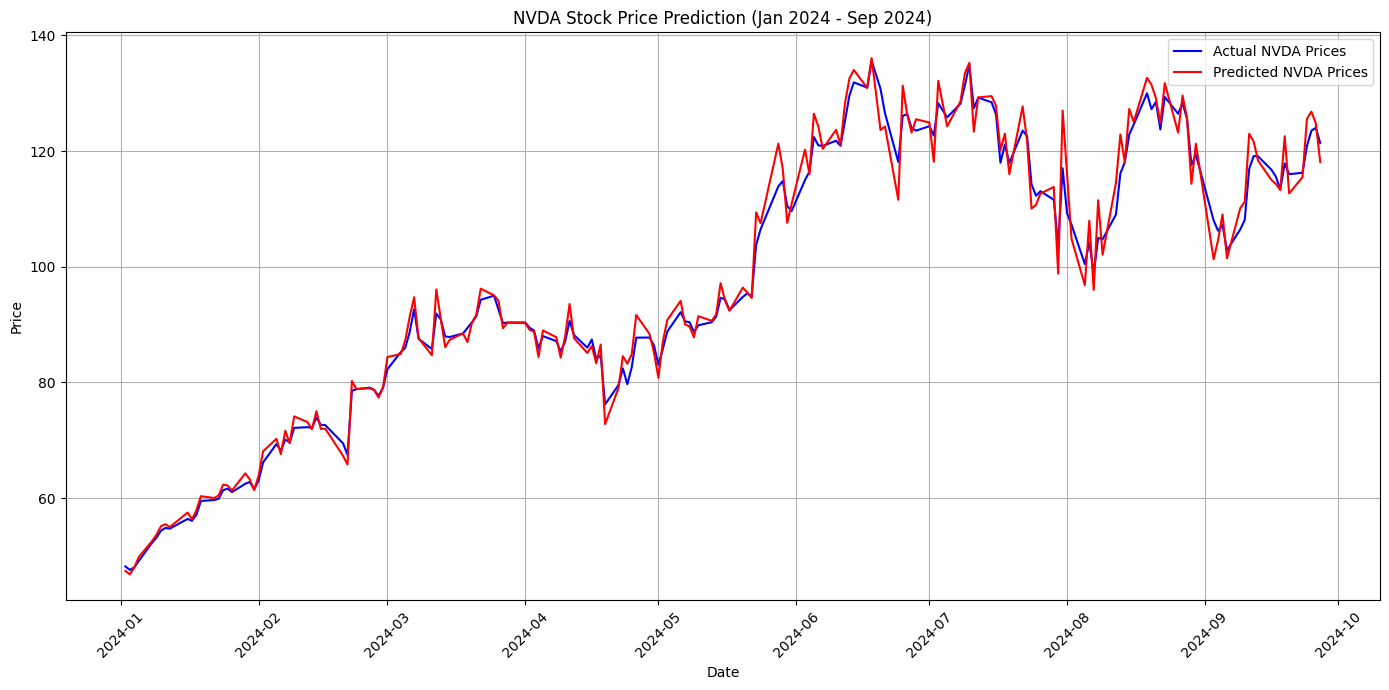

In [ ]:
predicted_nvda_returns = model_nvda.predict(X_nvda)
predicted_nvda_prices = nvda_prices[-len(predicted_nvda_returns):].values * (1 + predicted_nvda_returns)

# Create a DataFrame for the predicted prices
predicted_prices_df = pd.DataFrame({
    'Date': nvda_prices.index[-len(predicted_nvda_returns):],
    'Predicted': predicted_nvda_prices
})

# Create a DataFrame for actual prices
actual_prices_df = pd.DataFrame({
    'Date': nvda_prices.index,
    'Actual': nvda_prices.values
})

# Convert to datetime for filtering
actual_prices_df['Date'] = pd.to_datetime(actual_prices_df['Date'])
predicted_prices_df['Date'] = pd.to_datetime(predicted_prices_df['Date'])

# Filter for January 2024 to September 2024
start_date = '2024-01-01'
end_date = '2024-09-30'
actual_prices_filtered = actual_prices_df[(actual_prices_df['Date'] >= start_date) & (actual_prices_df['Date'] <= end_date)]
predicted_prices_filtered = predicted_prices_df[(predicted_prices_df['Date'] >= start_date) & (predicted_prices_df['Date'] <= end_date)]

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(actual_prices_filtered['Date'], actual_prices_filtered['Actual'], label='Actual NVDA Prices', color='blue')
plt.plot(predicted_prices_filtered['Date'], predicted_prices_filtered['Predicted'], label='Predicted NVDA Prices', color='red')
plt.title('NVDA Stock Price Prediction (Jan 2024 - Sep 2024)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.grid()
plt.tight_layout()  # Adjust layout for better fit
plt.show()

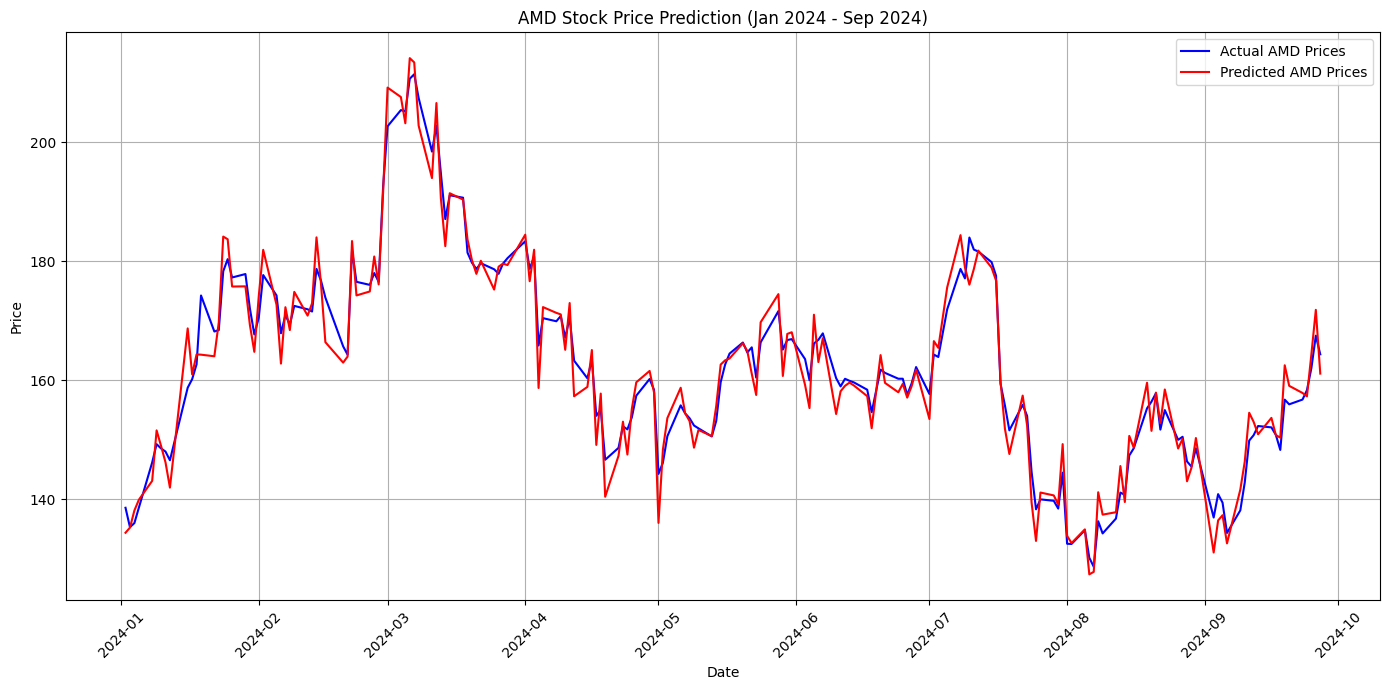

In [ ]:
predicted_amd_returns = model_amd.predict(X_amd)
predicted_amd_prices = amd_prices[-len(predicted_amd_returns):].values * (1 + predicted_amd_returns)

# Create a DataFrame for the predicted prices
predicted_prices_df = pd.DataFrame({
    'Date': amd_prices.index[-len(predicted_amd_returns):],
    'Predicted': predicted_amd_prices
})

# Create a DataFrame for actual prices
actual_prices_df = pd.DataFrame({
    'Date': amd_prices.index,
    'Actual': amd_prices.values
})

# Convert to datetime for filtering
actual_prices_df['Date'] = pd.to_datetime(actual_prices_df['Date'])
predicted_prices_df['Date'] = pd.to_datetime(predicted_prices_df['Date'])

# Filter for January 2024 to September 2024
start_date = '2024-01-01'
end_date = '2024-09-30'
actual_prices_filtered = actual_prices_df[(actual_prices_df['Date'] >= start_date) & (actual_prices_df['Date'] <= end_date)]
predicted_prices_filtered = predicted_prices_df[(predicted_prices_df['Date'] >= start_date) & (predicted_prices_df['Date'] <= end_date)]

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(actual_prices_filtered['Date'], actual_prices_filtered['Actual'], label='Actual AMD Prices', color='blue')
plt.plot(predicted_prices_filtered['Date'], predicted_prices_filtered['Predicted'], label='Predicted AMD Prices', color='red')
plt.title('AMD Stock Price Prediction (Jan 2024 - Sep 2024)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.grid()
plt.tight_layout()  # Adjust layout for better fit
plt.show()

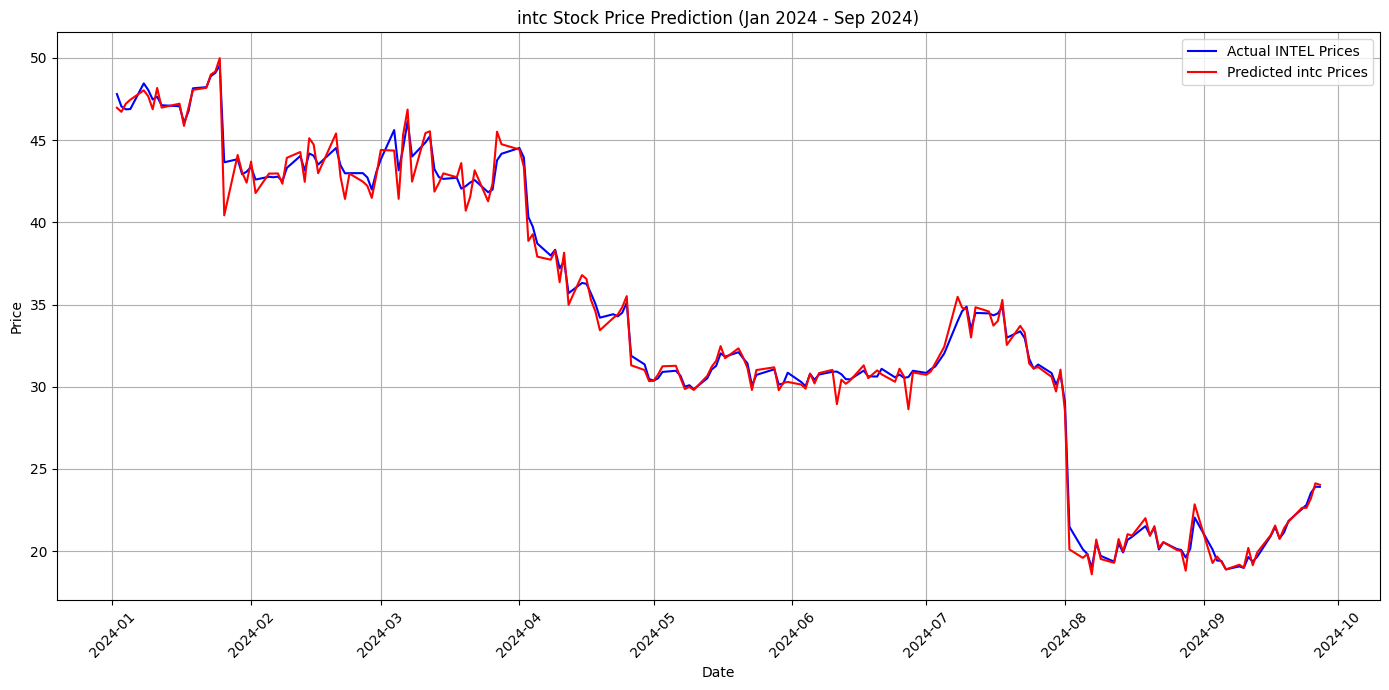

In [ ]:
predicted_intc_returns = model_intc.predict(X_intc)
predicted_intc_prices = intc_prices[-len(predicted_intc_returns):].values * (1 + predicted_intc_returns)

# Create a DataFrame for the predicted prices
predicted_prices_df = pd.DataFrame({
    'Date': intc_prices.index[-len(predicted_intc_returns):],
    'Predicted': predicted_intc_prices
})

# Create a DataFrame for actual prices
actual_prices_df = pd.DataFrame({
    'Date': intc_prices.index,
    'Actual': intc_prices.values
})

# Convert to datetime for filtering
actual_prices_df['Date'] = pd.to_datetime(actual_prices_df['Date'])
predicted_prices_df['Date'] = pd.to_datetime(predicted_prices_df['Date'])

# Filter for January 2024 to September 2024
start_date = '2024-01-01'
end_date = '2024-09-30'
actual_prices_filtered = actual_prices_df[(actual_prices_df['Date'] >= start_date) & (actual_prices_df['Date'] <= end_date)]
predicted_prices_filtered = predicted_prices_df[(predicted_prices_df['Date'] >= start_date) & (predicted_prices_df['Date'] <= end_date)]

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(actual_prices_filtered['Date'], actual_prices_filtered['Actual'], label='Actual INTEL Prices', color='blue')
plt.plot(predicted_prices_filtered['Date'], predicted_prices_filtered['Predicted'], label='Predicted intc Prices', color='red')
plt.title('intc Stock Price Prediction (Jan 2024 - Sep 2024)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.grid()
plt.tight_layout()  # Adjust layout for better fit
plt.show()

[*********************100%***********************]  3 of 3 completed


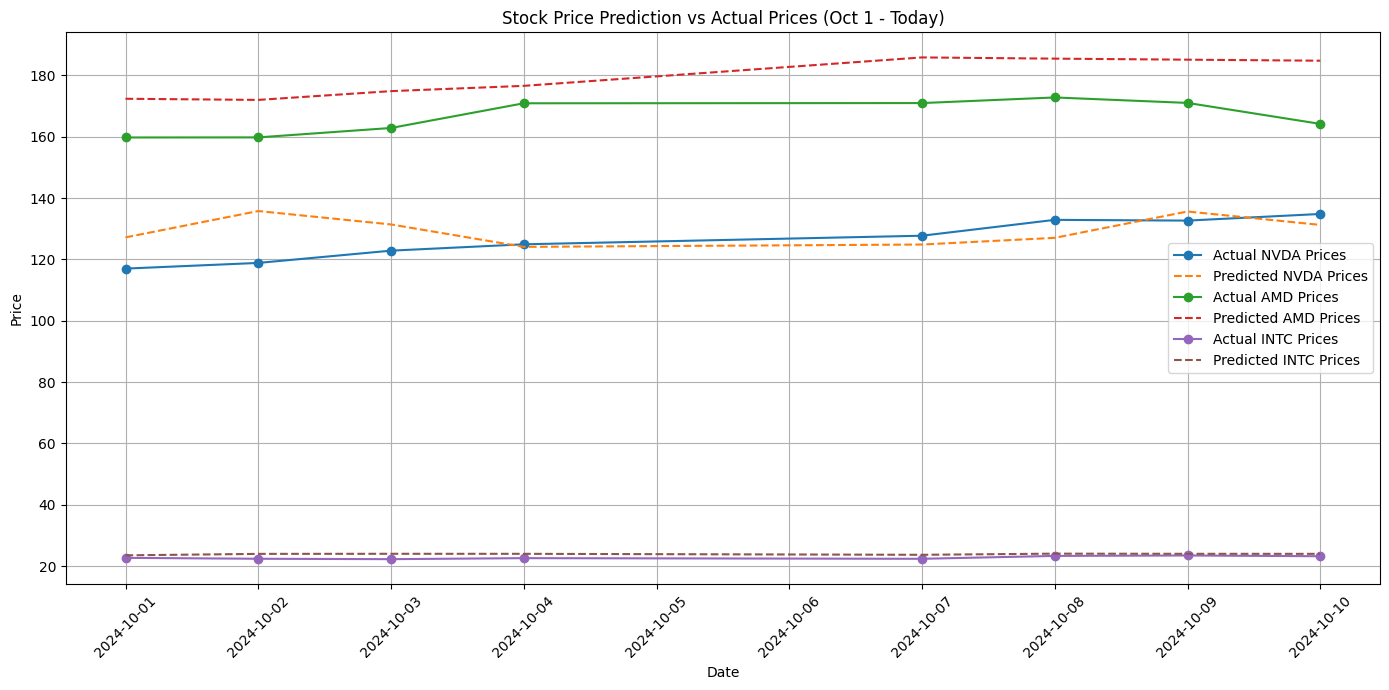

In [ ]:
from datetime import datetime

# Train models for each stock
results = {}
results['NVDA'] = model_nvda
results['AMD'] = model_amd
results['INTC'] = model_intc

# Set the test date range to today
test_start_date = '2024-10-01'
test_end_date = datetime.now().strftime('%Y-%m-%d')  # Current date

# Fetch real stock prices from October 1, 2024, to today
real_prices = yf.download(tickers, start=test_start_date, end=test_end_date)['Close']

# Prepare to predict stock prices for the new dates
predictions = {}

for ticker in tickers:
    model = results[ticker][0]
    # Use the last known price for prediction
    last_price = close_prices[ticker].iloc[-1]

    predicted_prices = []
    for _ in range(len(real_prices)):
        # Prepare input for prediction (previous day's price)
        X_input = np.array([[last_price]])
        predicted_return = model.predict(X_input)[0]

        # Calculate the predicted price
        last_price = last_price * (1 + predicted_return)  # Update last price with predicted return
        predicted_prices.append(last_price)

    predictions[ticker] = predicted_prices

# Create a DataFrame for the predicted prices
predicted_df = pd.DataFrame(predictions, index=real_prices.index)

# Plotting the results
plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(real_prices.index, real_prices[ticker], label=f'Actual {ticker} Prices', marker='o')
    plt.plot(real_prices.index, predicted_df[ticker], label=f'Predicted {ticker} Prices', linestyle='--')

plt.title('Stock Price Prediction vs Actual Prices (Oct 1 - Today)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


In [50]:
#Things to add: calculate the max error of each stock maybe. Over 24 years from the start of the datapoints until the end